In [1]:
import redback
import pandas as pd
from redback.photosphere import TemperatureFloor
from redback.simulate_transients import SimulateGenericTransient
from astropy.cosmology import Planck18 as cosmo
%pylab inline

22:04 bilby INFO    : Running bilby version: 2.3.1.dev100+g65bcde32
22:04 redback INFO    : Running redback version: 1.0.31


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### In this tutorial I will show how to use redback to get the blackbody temperature and radius as functions of time for any thermal optical transient.

### Note/Plea to users, this is an important point.

Flux density data is the only place where it actually makes sense to use the effective wavelength approximation (because the data is actually generated that way in the first place). The same is not true of magnitude or bandpass flux data, which are not some SED at a particular effective wavelength but instead an integration of the SED over the bandpass filter.

If you are estimating blackbody temperatures/radius from magnitude or bandpass flux data, its better to not use the effective wavelength approximation. Redback takes care of this internally by default but does give the user the option to not do the technically correct thing and allow people to be consistent with methods previously used. Note in some instances the difference may be marginal. However, the biases this introduces are subtle, especially if you then go on to try and infer properties at specific epochs. Redback gives you the option here to make the technically correct choice ... but you do what you want to.

#### End Note/Plea

# Example 1. The simple interface

Let's start by simulating some flux density data. 


In [2]:
bands = ['lsstg', 'lsstr', 'lssti', 'lsstu', 'lsstz', 'ztfg', 
         'ztfr', 'uvot::u', 'f150w', 'uvot::uvm2', 'uvot::uvw1', 'atlaso']
frequency = redback.utils.bands_to_frequency(bands)

times = np.geomspace(0.5, 50, 20)
times = np.append(times, np.linspace(50, 400, 100))
kappa = 0.07
kappa_gamma = 0.1
mej = 10
vej = 5000
nickel_mass = 1.5
tf = 1600
output_format = 'flux_density'
f_nickel = nickel_mass/mej
model_kwargs = {'output_format':output_format, 'frequency':frequency}
num_of_data_points = 250 # the number of data points to generate
parameters = {}
parameters['kappa'] = kappa
parameters['kappa_gamma'] = kappa_gamma
parameters['f_nickel'] = f_nickel
parameters['mej'] = mej
parameters['vej'] = vej
parameters['temperature_floor'] = tf
parameters['redshift'] = 0.01
distance = cosmo.luminosity_distance(parameters['redshift']).cgs.value

To make life easier, I will use the simulation modules within redback

22:04 redback WARNING : [Errno 2] No such file or directory: 'kilonova//my_kilonova_metadata.csv'
22:04 redback WARNING : Setting metadata to None. This is not an error, but a warning that no metadata could be found online.


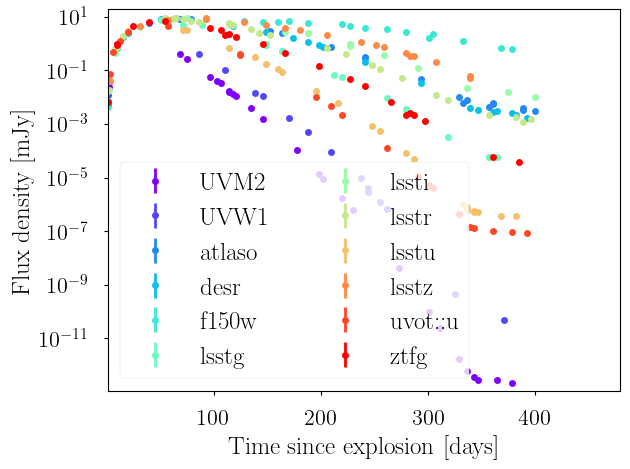

<Axes: xlabel='Time since explosion [days]', ylabel='Flux density [mJy]'>

In [3]:
# generate the true temperature and radius as well, this is necessary for later.
func = redback.model_library.all_models_dict['arnett_bolometric']
lbol_a = func(times, f_nickel=f_nickel, mej=mej, vej=vej, kappa=kappa,
                         kappa_gamma=kappa_gamma, temperature_floor=tf)
photo = TemperatureFloor(times, luminosity=lbol_a, vej=vej, temperature_floor=tf)

# simulation module 
kn_obs = SimulateGenericTransient(model='arnett', parameters=parameters, times=times, 
                                  data_points=num_of_data_points, model_kwargs=model_kwargs, 
                                 multiwavelength_transient=True, noise_term=0.1)
bbnames = redback.utils.frequency_to_bandname(kn_obs.data['frequency'].values)
kilonova = redback.transient.Kilonova(name='my_kilonova', flux_density=kn_obs.data['output'].values,
                                      time=kn_obs.data['time'].values, data_mode=output_format,
                                      flux_density_err=kn_obs.data['output_error'].values, 
                                      frequency=kn_obs.data['frequency'].values, 
                                      bands=bbnames, redshift=parameters['redshift'])
kilonova.plot_data()

redback's transient objecy provides a simple interface which automagically provides you your estimated properties at various epochs. 

Let's use that

In [4]:
# these can be passed to the method, 
# here we use the default values which are used if nothing is passed. 
bin_width = 1 # width with which to bin the data in days,
min_filters = 3 # minimum number of filters/frequencies the epoch must have to be fit.

# Some other things can also be passed to this function, look at the API.
df_bb = kilonova.estimate_bb_params(distance=distance, bin_width=bin_width, 
                                    min_filters=min_filters)
# We are returned a dataframe with time, temperature, radius, and the errors. 

22:04 redback INFO    : Estimating blackbody parameters for my_kilonova.
22:04 redback INFO    : Using data mode = flux_density
22:04 redback INFO    : Using effective wavelength approximation for flux_density
22:04 redback INFO    : Number of bins: 401
22:04 redback INFO    : Masking epochs with likely wrong extractions


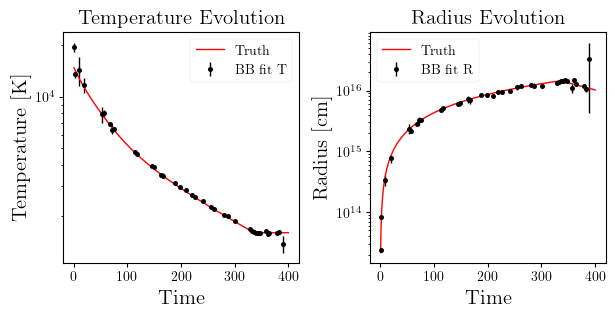

In [5]:
# We can use the returned dataframe for plotting, 
# and lets also compare to our real truth.

# Plot Temperature: discrete blackbody fits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

ax1.errorbar(df_bb['epoch_times'], df_bb['temperature'], yerr=df_bb['temp_err'],
             fmt='ko', label="BB fit T")
ax2.errorbar(df_bb['epoch_times'], df_bb['radius'], yerr=df_bb['radius_err'],
             fmt='ko', label="BB fit R")
ax1.plot(times, photo.photosphere_temperature, color='red', label='Truth')
ax2.plot(times, photo.r_photosphere, color='red', label='Truth')

ax1.set_xlabel("Time", fontsize=15)
ax1.set_ylabel("Temperature [K]", fontsize=15)
ax1.set_title("Temperature Evolution", fontsize=15)

ax2.set_xlabel("Time", fontsize=15)
ax2.set_ylabel("Radius [cm]", fontsize=15)
ax2.set_title("Radius Evolution", fontsize=15)

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.legend()
ax2.legend()
plt.subplots_adjust(wspace=0.3)

Because we can, and also because curve fit is likely to underestimate errors and is also not actually robust and can sometimes gives estimates that are clearly wrong... (this is one of the reasons why we do full inference...) let's also GP interpolate between different epochs

Again, I will use the redback interface, but we do need to set up some kernels

22:04 redback INFO    : Finished GP fit for temperature
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', 21.147335122376727), ('kernel:k2:metric:log_M_0_0', 15.060401207119108)])
22:04 redback INFO    : Finished GP fit for radius
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', 73.74918546632385), ('kernel:k2:metric:log_M_0_0', 12.820469295057746)])


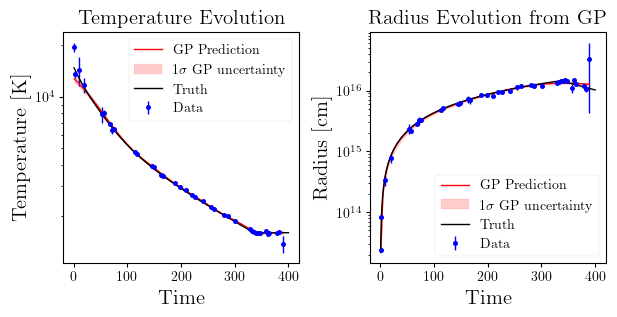

In [6]:
from george import kernels

# things are mostly smooth so there is no reason to 
# set a small scale or anything fancy with the kernel

kernel_T = np.var(df_bb['temperature'].values) * kernels.Matern32Kernel(metric=1.0)
kernel_R = np.var(df_bb['radius'].values) * kernels.Matern32Kernel(metric=1.0)

# Use the analysis module and also return a nice plot of everything.
gp_T, gp_R, fig, axes = redback.analysis.fit_temperature_and_radius_gp(data=df_bb,
                                                                      kernelT=kernel_T,
                                                                      kernelR=kernel_R,
                                                                      plot=True)
# Because we actually know the true values here, lets add that in. 
axes[0].plot(times, photo.photosphere_temperature, color='black', label='Truth')
axes[1].plot(times, photo.r_photosphere, color='black', label='Truth')
axes[0].legend()
axes[1].legend()

# Now we have a continous representation of our blackbody radius and temperature
# and a nice plot!

# Example 2: What happens if we dont have enough data points or epochs. 

22:04 redback WARNING : [Errno 2] No such file or directory: 'kilonova//my_kilonova_metadata.csv'
22:04 redback WARNING : Setting metadata to None. This is not an error, but a warning that no metadata could be found online.


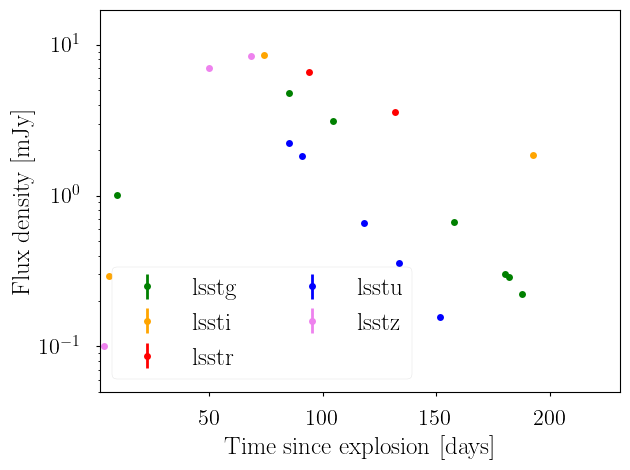

<Axes: xlabel='Time since explosion [days]', ylabel='Flux density [mJy]'>

In [7]:
# Same as before but with number of data points reduced

np.random.seed(123456)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstu', 'lsstz']
frequency = redback.utils.bands_to_frequency(bands)

# let's also add some sensible colours to the plot 
band_colors = {'lsstg':'green', 'lsstr':'red', 
                'lssti':'orange', 'lsstu':'blue', 'lsstz':'violet'}

times = np.geomspace(0.5, 50, 20)
times = np.append(times, np.linspace(50, 200, 100))
kappa = 0.07
kappa_gamma = 0.1
mej = 10
vej = 5000
nickel_mass = 1.5
tf = 1600
f_nickel = nickel_mass/mej

output_format = 'flux_density'
model_kwargs = {'output_format':output_format, 'frequency':frequency}

num_of_data_points = 20 # the number of data points to generate
parameters = {}
parameters['kappa'] = kappa
parameters['kappa_gamma'] = kappa_gamma
parameters['f_nickel'] = f_nickel
parameters['mej'] = mej
parameters['vej'] = vej
parameters['temperature_floor'] = tf
parameters['redshift'] = 0.01
distance = cosmo.luminosity_distance(parameters['redshift']).cgs.value

func = redback.model_library.all_models_dict['arnett_bolometric']
lbol_a = func(times, f_nickel=f_nickel, mej=mej, vej=vej, kappa=kappa,
                         kappa_gamma=kappa_gamma, temperature_floor=tf)
photo = TemperatureFloor(times, luminosity=lbol_a, vej=vej, temperature_floor=tf)

kn_obs = SimulateGenericTransient(model='arnett', parameters=parameters, times=times, 
                                  data_points=num_of_data_points, model_kwargs=model_kwargs, 
                                 multiwavelength_transient=True, noise_term=0.01)
bbnames = redback.utils.frequency_to_bandname(kn_obs.data['frequency'].values)
kilonova = redback.transient.Kilonova(name='my_kilonova', flux_density=kn_obs.data['output'].values,
                                      time=kn_obs.data['time'].values, data_mode=output_format,
                                      flux_density_err=kn_obs.data['output_error'].values, 
                                      frequency=kn_obs.data['frequency'].values, 
                                      bands=bbnames, redshift=parameters['redshift'])
kilonova.plot_data(band_colors=band_colors)

In [8]:
df_bb = kilonova.estimate_bb_params(distance=distance)

22:04 redback INFO    : Estimating blackbody parameters for my_kilonova.
22:04 redback INFO    : Using data mode = flux_density
22:04 redback INFO    : Using effective wavelength approximation for flux_density
22:04 redback INFO    : Number of bins: 190
22:04 redback WARNING : No time bins have at least 3 measurements. Fitting cannot proceed.
22:04 redback WARNING : Try generating more data through GPs, increasing bin widths, or using fewer filters.


There simply isnt enough data points to do what we want to. But, don't stress, this is another place where we can leverage the beauty of GPs.

Let's start by making some gp interpolations of the data and again, we are gonna use the redback interface. Exactly how to do this is not the purpose of this tutorial, look at the GP examples available in the main repository. 

22:04 redback INFO    : Rescaling data for GP fitting.
22:04 redback INFO    : Using frequencies and time in the GP fit.
22:04 redback INFO    : Kernel used: ConstantKernel(log_constant=0.33296308359141924, ndim=2, axes=array([0, 1])) * Matern32Kernel(metric=Metric(array([9.27662669e+28, 1.00000000e+02]), ndim=2, axes=array([0, 1]), bounds=[(None, None), (None, None)]), block=None)
22:04 redback INFO    : Ensure that the kernel is set up correctly for 2D GP.
22:04 redback INFO    : You will be returned a single GP object with frequency as a parameter
22:04 redback INFO    : Mean model not given, fitting GP with no mean model.
22:04 redback INFO    : GP final loglikelihood: 22.978735062888774
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', -1.6915953386418183), ('kernel:k2:metric:log_M_0_0', 69.22380043432197), ('kernel:k2:metric:log_M_1_1', 10.042638203273492)])


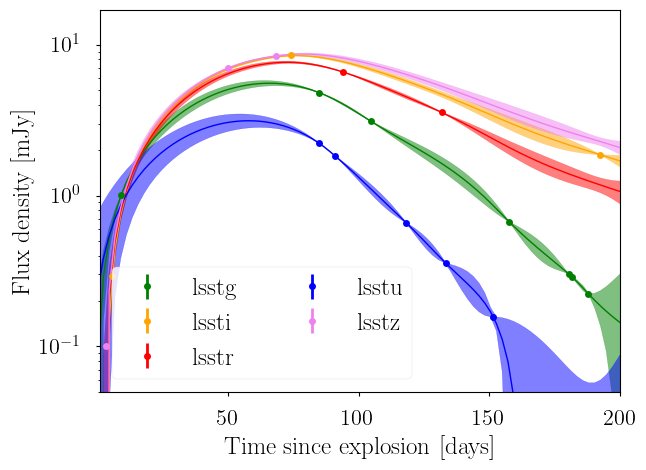

In [9]:
sn = kilonova
k1 = kernels.ConstantKernel(np.std(sn.y/sn.y.max()), ndim=2)
k2 = kernels.Matern32Kernel([np.var(np.diff(sn.unique_frequencies)), 100], ndim=2)
kernel = k1 * k2

out = sn.fit_gp(mean_model=None, kernel=kernel, use_frequency=True)
ax = sn.plot_data(show=False, band_colors=band_colors)
ax.set_xscale("linear")
ax.set_xlim(1, 200)

ax = redback.analysis.plot_gp_lightcurves(sn, gp_output=out, axes=ax, 
                                          band_colors=band_colors)

The interpolation seems pretty reasonable out to atleast 150 days. Let's generate a new transient object by drawing some "new" data from the GP interpolation. 

A GP representation means we can create data at any time, so we deliberately generate all wavelengths and at several timesteps we are interested in.

22:04 redback INFO    : Data mode: flux_density
22:04 redback INFO    : Creating new flux_density data
22:04 redback INFO    : GP is a 2D kernel with effective frequency
22:04 redback INFO    : Data mode: flux_density
22:04 redback INFO    : Creating new transient object with GP data


(10.0, 150.0)

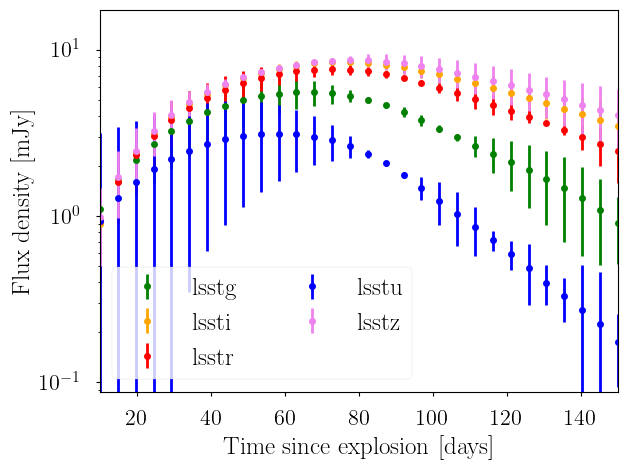

In [10]:
# create new time array that we want to look at 
t_new = np.linspace(10, 150, 30)
# generate new transient object with the GP interpolation, 
# I am adding an error here to the standard GP std estimate to capture the variance
# of the full 1D interval. Setting this to one will not do this. 
# This is a by eye thing here but you can do this more formally
# by generating lots of draws from the GP and getting an estimate of errors
new_sn = redback.analysis.generate_new_transient_data_from_gp(out, t_new=t_new, 
                                                             transient=sn, error=20)
ax = new_sn.plot_data(show=False, band_colors=band_colors)
ax.set_xlim(10, 150)

We can now use this transient object as we did previously, I will do the full GP thing in one step here.

22:04 redback INFO    : Estimating blackbody parameters for my_kilonova_gp.
22:04 redback INFO    : Using data mode = flux_density
22:04 redback INFO    : Using effective wavelength approximation for flux_density
22:04 redback INFO    : Number of bins: 141
22:04 redback INFO    : Masking epochs with likely wrong extractions
22:04 redback INFO    : Finished GP fit for temperature
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', 17.67183313936189), ('kernel:k2:metric:log_M_0_0', 12.560188195152634)])
22:04 redback INFO    : Finished GP fit for radius
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', 72.2252416002354), ('kernel:k2:metric:log_M_0_0', 11.513869847997439)])


(10.0, 150.0)

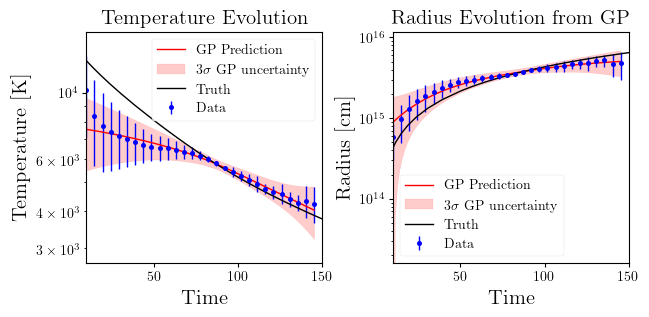

In [11]:
df_bb = new_sn.estimate_bb_params(distance=distance, bin_width=bin_width, 
                                    min_filters=min_filters)

# Same kernels as before 
kernel_T = np.var(df_bb['temperature'].values) * kernels.Matern32Kernel(metric=1.0)
kernel_R = np.var(df_bb['radius'].values) * kernels.Matern32Kernel(metric=1.0)

# Use the analysis module and also return a nice plot of everything.
# lets also plot the 3sigma interval instead
gp_T, gp_R, fig, axes = redback.analysis.fit_temperature_and_radius_gp(data=df_bb,
                                                                      kernelT=kernel_T,
                                                                      kernelR=kernel_R,
                                                                      plot=True,
                                                                      sigma_to_plot=3)
# Because we actually know the true values here, lets add that in. 
axes[0].plot(times, photo.photosphere_temperature, color='black', label='Truth')
axes[1].plot(times, photo.r_photosphere, color='black', label='Truth')

# axes[0].plot(times, gp_T.)

axes[0].legend()
axes[1].legend()
axes[0].set_xlim(10, 150)
axes[1].set_xlim(10, 150)

Considering those errorbars are one sigma, and the GP is a just super quick optimization this is not bad at all considering all the missing data.

# Example 3: Magnitude/Flux data

The above examples dealt with flux density data, where as I made a note before, it makes sense to use the effective wavelength approximation. Here I will show what happens when you actually have magnitude/flux data generated without this approximation but you use it to estimate stuff anyway. 

22:04 redback WARNING : [Errno 2] No such file or directory: 'kilonova//my_kilonova_metadata.csv'
22:04 redback WARNING : Setting metadata to None. This is not an error, but a warning that no metadata could be found online.


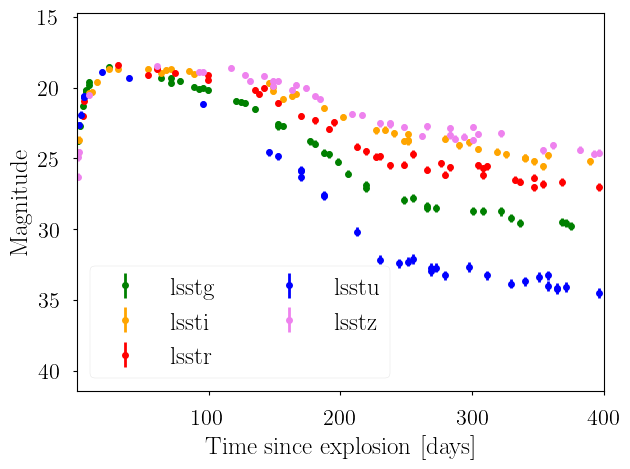

<Axes: xlabel='Time since explosion [days]', ylabel='Magnitude'>

In [12]:
np.random.seed(126)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstu', 'lsstz']

# let's also add some sensible colours to the plot 
band_colors = {'lsstg':'green', 'lsstr':'red', 
                'lssti':'orange', 'lsstu':'blue', 'lsstz':'violet'}

times = np.geomspace(0.5, 50, 20)
times = np.append(times, np.linspace(50, 400, 100))
kappa = 0.07
kappa_gamma = 0.1
mej = 3
vej = 8000
nickel_mass = 2.5
tf = 2100
f_nickel = nickel_mass/mej
output_format = 'magnitude'
model_kwargs = {'output_format':output_format, 'bands':bands}
num_of_data_points = 200 # the number of data points to generate
parameters = {}
parameters['kappa'] = kappa
parameters['kappa_gamma'] = kappa_gamma
parameters['f_nickel'] = f_nickel
parameters['mej'] = mej
parameters['vej'] = vej
parameters['temperature_floor'] = tf
parameters['redshift'] = 0.1
distance = cosmo.luminosity_distance(parameters['redshift']).cgs.value

func = redback.model_library.all_models_dict['arnett_bolometric']
lbol_a = func(times, f_nickel=f_nickel, mej=mej, vej=vej, kappa=kappa,
                         kappa_gamma=kappa_gamma, temperature_floor=tf)
photo = TemperatureFloor(times, luminosity=lbol_a, vej=vej, temperature_floor=tf)

kn_obs = SimulateGenericTransient(model='arnett', parameters=parameters, times=times, 
                                  data_points=num_of_data_points, model_kwargs=model_kwargs, 
                                 multiwavelength_transient=True, noise_term=0.01)

transient = redback.transient.Kilonova(name='my_kilonova', 
                                       magnitude=kn_obs.data['output'].values,
                                      time=kn_obs.data['time'].values, 
                                       data_mode=output_format,
                                      magnitude_err=kn_obs.data['output_error'].values,  
                                      bands=kn_obs.data['band'].values, 
                                       redshift=parameters['redshift'])
transient.plot_data(band_colors=band_colors, ms=5, xlim_high=400)

This is simulated data so we know the true input. Let's see what happens when we fit for the blackbody temperature and radius using the effective wavelength approximation.

22:04 redback INFO    : Estimating blackbody parameters for my_kilonova.
22:04 redback INFO    : Using data mode = magnitude
22:04 redback WARNING : Using effective wavelength approximation for magnitude
22:04 redback INFO    : Number of bins: 397
22:04 redback INFO    : Masking epochs with likely wrong extractions
22:04 redback INFO    : Finished GP fit for temperature
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', 2.9476236765747976), ('kernel:k2:metric:log_M_0_0', 15.4899230770792)])
22:04 redback INFO    : Finished GP fit for radius
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', 72.61358499271061), ('kernel:k2:metric:log_M_0_0', 11.238496560707027)])


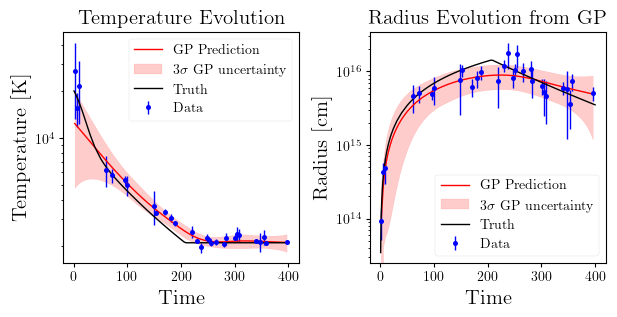

In [13]:
# Set the flag use_eff_wavelength = True to force the behaviour
# Redback will return a warning about this
df_bb = transient.estimate_bb_params(distance=distance, use_eff_wavelength=True)

kernel_T = np.var(df_bb['temperature'].values) * kernels.Matern32Kernel(metric=100.0)
kernel_R = np.var(df_bb['radius'].values) * kernels.Matern32Kernel(metric=100.0)

# Use the analysis module and also return a nice plot of everything.
# Because the temperature scale is suggesting a sharp drop, 
# we are also going to fit in logT to ensure the GP interpolation captures this.
gp_T, gp_R, fig, axes = redback.analysis.fit_temperature_and_radius_gp(data=df_bb,
                                                                      kernelT=kernel_T,
                                                                      kernelR=kernel_R,
                                                                      plot=True, 
                                                                      fit_in_log=True, 
                                                                      sigma_to_plot=3)
# Because we actually know the true values here, lets add that in. 
axes[0].plot(times, photo.photosphere_temperature, color='black', label='Truth')
axes[1].plot(times, photo.r_photosphere, color='black', label='Truth')
axes[0].legend()
axes[1].legend()

So, this is not bad, we are broadly getting the right solution. But this is not really a hot transient, which is where the approximation really starts to struggle. We are overconstraining at some times, such that at some epochs we are in tension with the data at greater than $3\sigma$ which is a combination of curvefit and the intrinsic scatter stemming from the flux density approximation. I encourage you to try this same exercise with a TDE/shock cooling etc...

So what happens if we don't use the effective wavelength approximation.

22:04 redback INFO    : Estimating blackbody parameters for my_kilonova.
22:04 redback INFO    : Using data mode = magnitude
22:04 redback INFO    : Number of bins: 397
22:04 redback INFO    : Masking epochs with likely wrong extractions
22:04 redback INFO    : Finished GP fit for temperature
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', 2.9668820400535902), ('kernel:k2:metric:log_M_0_0', 15.507587246004018)])
22:04 redback INFO    : Finished GP fit for radius
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', 72.82055483101425), ('kernel:k2:metric:log_M_0_0', 11.187900227604162)])


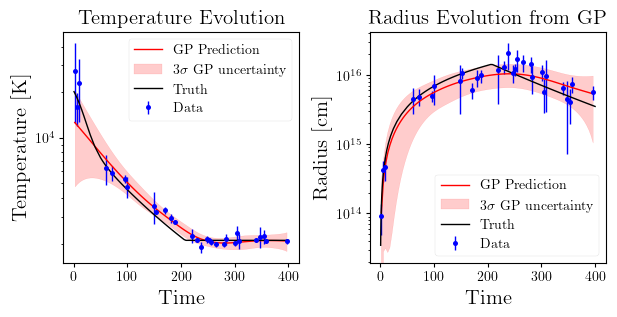

In [14]:
df_bb = transient.estimate_bb_params(distance=distance)

kernel_T = np.var(df_bb['temperature'].values) * kernels.Matern32Kernel(metric=10.0)
kernel_R = np.var(df_bb['radius'].values) * kernels.Matern32Kernel(metric=100.0)

# Use the analysis module and also return a nice plot of everything.
# Because the temperature scale is suggesting a sharp drop, 
# we are also going to fit in logT to ensure the GP interpolation captures this.
gp_T, gp_R, fig, axes = redback.analysis.fit_temperature_and_radius_gp(data=df_bb,
                                                                      kernelT=kernel_T,
                                                                      kernelR=kernel_R,
                                                                      plot=True, 
                                                                      fit_in_log=True, 
                                                                      sigma_to_plot=3)
# Because we actually know the true values here, lets add that in. 
axes[0].plot(times, photo.photosphere_temperature, color='black', label='Truth')
axes[1].plot(times, photo.r_photosphere, color='black', label='Truth')
axes[0].legend()
axes[1].legend()

We get a broadly similar result, but the caveats mentioned apply. Now lets see what happens when you work in bandpass flux instead...

# Example 4: Bandpass flux data, for the sake of completeness

If you have bandpass flux data the behaviour is exactly the same as if you had magnitude data.

Let's show you how

22:04 redback WARNING : [Errno 2] No such file or directory: 'kilonova//my_kilonova_metadata.csv'
22:04 redback WARNING : Setting metadata to None. This is not an error, but a warning that no metadata could be found online.


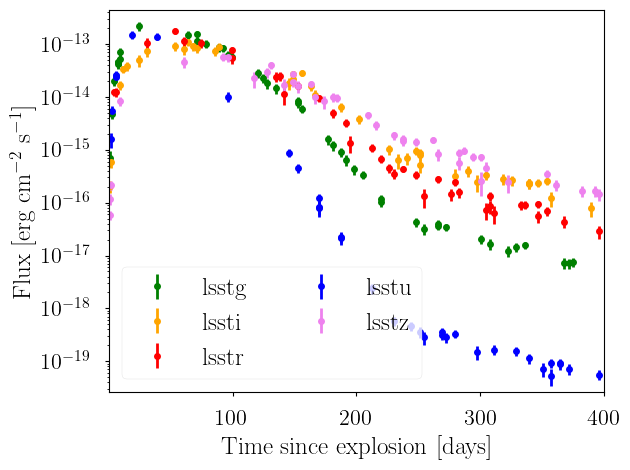

<Axes: xlabel='Time since explosion [days]', ylabel='Flux [erg cm$^{-2}$ s$^{-1}$]'>

In [15]:
np.random.seed(126)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstu', 'lsstz']

# let's also add some sensible colours to the plot 
band_colors = {'lsstg':'green', 'lsstr':'red', 
                'lssti':'orange', 'lsstu':'blue', 'lsstz':'violet'}

times = np.geomspace(0.5, 50, 20)
times = np.append(times, np.linspace(50, 400, 100))
kappa = 0.07
kappa_gamma = 0.1
mej = 3
vej = 8000
nickel_mass = 2.5
tf = 2100
f_nickel = nickel_mass/mej
output_format = 'flux'
model_kwargs = {'output_format':output_format, 'bands':bands}
num_of_data_points = 200 # the number of data points to generate
parameters = {}
parameters['kappa'] = kappa
parameters['kappa_gamma'] = kappa_gamma
parameters['f_nickel'] = f_nickel
parameters['mej'] = mej
parameters['vej'] = vej
parameters['temperature_floor'] = tf
parameters['redshift'] = 0.1
distance = cosmo.luminosity_distance(parameters['redshift']).cgs.value

func = redback.model_library.all_models_dict['arnett_bolometric']
lbol_a = func(times, f_nickel=f_nickel, mej=mej, vej=vej, kappa=kappa,
                         kappa_gamma=kappa_gamma, temperature_floor=tf)
photo = TemperatureFloor(times, luminosity=lbol_a, vej=vej, temperature_floor=tf)

kn_obs = SimulateGenericTransient(model='arnett', parameters=parameters, times=times, 
                                  data_points=num_of_data_points, 
                                  model_kwargs=model_kwargs, 
                                 multiwavelength_transient=True, noise_term=0.2)

transient = redback.transient.Kilonova(name='my_kilonova', 
                                       flux=kn_obs.data['output'].values,
                                      time=kn_obs.data['time'].values, 
                                       data_mode=output_format,
                                      flux_err=kn_obs.data['output_error'].values,  
                                      bands=kn_obs.data['band'].values, 
                                       redshift=parameters['redshift'])
transient.plot_data(band_colors=band_colors, ms=5, xlim_high=400)

Now what happens if you used the effective wavelength approximation?

22:04 redback INFO    : Estimating blackbody parameters for my_kilonova.
22:04 redback INFO    : Using data mode = flux
22:04 redback WARNING : Using effective wavelength approximation for flux
22:04 redback WARNING : Ensure filters.csv has the correct bandpass effective widths for your filter.
22:04 redback INFO    : Number of bins: 397
22:04 redback INFO    : Masking epochs with likely wrong extractions


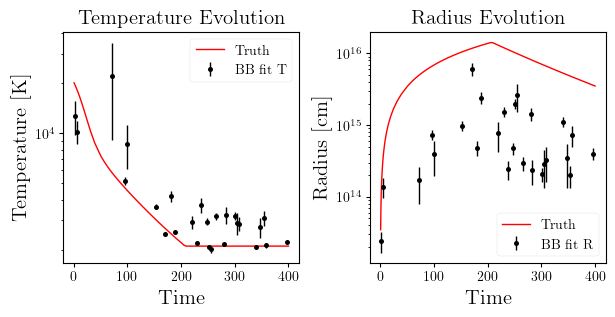

In [16]:
df_bb = transient.estimate_bb_params(distance=distance, use_eff_wavelength=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

ax1.errorbar(df_bb['epoch_times'], df_bb['temperature'], yerr=df_bb['temp_err'],
             fmt='ko', label="BB fit T")
ax2.errorbar(df_bb['epoch_times'], df_bb['radius'], yerr=df_bb['radius_err'],
             fmt='ko', label="BB fit R")
ax1.plot(times, photo.photosphere_temperature, color='red', label='Truth')
ax2.plot(times, photo.r_photosphere, color='red', label='Truth')

ax1.set_xlabel("Time", fontsize=15)
ax1.set_ylabel("Temperature [K]", fontsize=15)
ax1.set_title("Temperature Evolution", fontsize=15)

ax2.set_xlabel("Time", fontsize=15)
ax2.set_ylabel("Radius [cm]", fontsize=15)
ax2.set_title("Radius Evolution", fontsize=15)

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.legend()
ax2.legend()
plt.subplots_adjust(wspace=0.3)

We don't need a GP to see this has gone really badly. The effective wavelength approximation starts to hurt us here a lot, because its really difficult to distill the integrated flux over a bandpass to a flux density over a single effective wavelength either using an effective wavelength of the filter and the effective width. Magnitudes do not suffer from this as much (but still can), because magnitudes have some level of calibration built in already from the effective_wavelength of the filter.

Just to prove that it does work if you dont use the effective wavelength approximation.

22:04 redback INFO    : Estimating blackbody parameters for my_kilonova.
22:04 redback INFO    : Using data mode = flux
22:04 redback INFO    : Number of bins: 397
22:04 redback INFO    : Masking epochs with likely wrong extractions
22:04 redback INFO    : Finished GP fit for temperature
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', 3.0033874524419852), ('kernel:k2:metric:log_M_0_0', 15.449196924730613)])
22:04 redback INFO    : Finished GP fit for radius
22:04 redback INFO    : GP final parameters: OrderedDict([('kernel:k1:log_constant', 72.9425018418225), ('kernel:k2:metric:log_M_0_0', 11.042424994963302)])


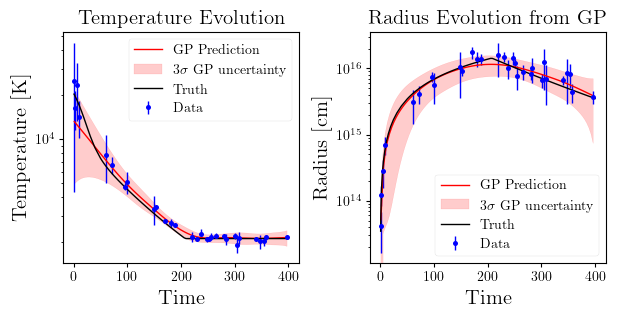

In [17]:
df_bb = transient.estimate_bb_params(distance=distance)

kernel_T = np.var(df_bb['temperature'].values) * kernels.Matern32Kernel(metric=1000.0)
kernel_R = np.var(df_bb['radius'].values) * kernels.Matern32Kernel(metric=1000.0)

# Use the analysis module and also return a nice plot of everything.
# Because the temperature scale is suggesting a sharp drop, 
# we are also going to fit in logT to ensure the GP interpolation captures this.
gp_T, gp_R, fig, axes = redback.analysis.fit_temperature_and_radius_gp(data=df_bb,
                                                                      kernelT=kernel_T,
                                                                      kernelR=kernel_R,
                                                                      plot=True, 
                                                                      fit_in_log=True, 
                                                                      sigma_to_plot=3)
# Because we actually know the true values here, lets add that in. 
axes[0].plot(times, photo.photosphere_temperature, color='black', label='Truth')
axes[1].plot(times, photo.r_photosphere, color='black', label='Truth')
axes[0].legend()
axes[1].legend()

Looks like a pretty good match to the data.

## Hopefully by the end of this tutorial you are comfortable with using redback to estimate blackbody temperatures and radius. Please check out other examples for other things redback can do.